# COGS 108 - Final Project 

# Overview

In this notebook, I investigate the Wake County health department's health inspections. Through visualization and exploratory analysis, I showcase that health inspection scores are likely being subjected to inflation. This inflation can stem from several sources, but I identify that inspectors themselves may be directly responsible for this phenomenon. Additionally, I uncover that health violations that are most often corrected during the inspection, are also the most likely to be consistently repeated.

This signifies a lack of objectivity in grading criteria, and perhaps a low effectiveness in health inspections. Future inspection guidelines should work to preserve integrity, and emphasize a non-arbitrary grading system.

# Name & GH Username

- Name: David Lopez
- GH Username: sourwurm

# Research Question

Are restaurants being accurately scored during health inspections?

## Background and Prior Work

The food safety industry faces a number of challenges, such as deciding what should be enforced, how often a restaurant should be visited, and how to fund inspections [1]. When a restaurant receives a low grade, the restaurant must shut down and a re-inspection must take place once the violations have been corrected[1]. This requirement is financially damaging to both the inspecting authority and the restaurant[1]. Thus, it is in everyones best interest for restaurants to score well on inspections.

When it comes to the regulations themselves, it is difficult to decide what rules should be dropped and which should remain, as even the most harmless of violation are looked at a "better safe than sorry" approach [2]. Even so, the most common violations seem to be the most easily looked over, such as improper cooling and heating of food, and improper handwashing [3]. These sorts of things won't necessarily take an A+ graded restaurant to a B-, but seeing as how these easily-forgotten tasks keep popping up, I believe there is a larger pattern to be drawn.

References (include links):
- 1) Stueven, Harlan. “Challenges of Health Department Food Safety Inspections.” Food Safety Magazine, www.foodsafetymagazine.com/enewsletter/challenges-of-health-department-food-safety-inspections/.
- 2) Roos, Dave. “How Restaurant Health Inspections Work.” HowStuffWorks, HowStuffWorks, 18 Oct. 2017, recipes.howstuffworks.com/tools-and-techniques/restaurant-health-inspections.htm.
- 3) Rice, Cindy. “Top 10 Restaurant Food Safety Violations.” Clean with Keystone, www.cleanwithkeystone.com/news-and-insights/top-10-food-safety-violations.
- 4) Stueven, Harlan. “Dine out with Confidence.” Dining Grades - Restaurant Food Safety Ratings, www.dininggrades.com/.

# Hypothesis


Health inspections are experiencing inflated scores, despite health code violations. This would be confirmed by empirical trends that would suggest a low score, but in reality a high score is reported. 

As the situation currently stands, both the establishment and inspecting agency can benefit from a high inspection score. To protect the public and reliability of health inspections, efforts must be made to ensure that the real world is reflective of this idea of integrity in scoring. The implications of a confirmed hypothesis would imply that systematic inflation is occurring within the health department for one reason or another. Depending on the findings of this report, more investigations may be required.

If no suggestions of score inflation are uncovered, then this hypothesis should be considered null. From there, further investigations could explore other avenues of improving health inspections.

# Dataset(s)


- Dataset Name: Food Inspections
- Link to the dataset: http://data-wake.opendata.arcgis.com/datasets/food-inspections
- Number of observations: 18466
<br>
Dataset containg information on findings for restaurant health inspections in North Carolina. Contains data on the inspector, and key notes on their findings.
<br> <br>
- Dataset Name: Food Violations
- Link to the dataset: http://data-wake.opendata.arcgis.com/datasets/food-inspection-violations
- Number of observations: 189802
Dataset containing every recorded violation for each inspections. Violations are grouped by a restaurant ID and inspection ID.

I plan to combine these two datasets by using the violations data set to get more in-depth information on overall inspections. The inspections dataset serves to provide general information.

# Setup

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#reading in data
inspect = pd.read_csv('data/inspections.csv')
viol = pd.read_csv('data/violations.csv')
geo = pd.read_csv('data/restaurants.csv')

# Data Cleaning

This data was provided in an already rather clean format for my intents and purposes. The majority of what I did is simply drop unneeded columns, such as ones that contained information that could invade the privacy of specific individuals or establishments. However, I did require the inspector_id column from the inspections dataset. I was unsure if this ID was already a dummy ID, but just to be safe I factorized the column so each individual was given a new unique ID that would preserve anonymity.

Throughout the project I perform several manipulations on slices of the dataframes that require special cleaning. Some of these changes are things I would like to keep seperate from the main data. Thus, further cleaning will be done throughout the notebook on a case-by-case basis.

In [3]:
print('Inspect Shape:', inspect.shape)
print('Viol Shape:', viol.shape)

Inspect Shape: (18466, 36)
Viol Shape: (189802, 18)


In [4]:
inspect.columns

Index(['hsisid', 'date', 'name', 'address1', 'address2', 'city', 'state',
       'postalcode', 'phonenumber', 'restaurantopendate',
       'days_from_open_date', 'facilitytype', 'x', 'y', 'geocodestatus', 'zip',
       'type', 'description', 'inspectedby', 'inspection_num', 'inspector_id',
       'previous_inspection_date', 'days_since_previous_inspection',
       'previous_inspection_by_same_inspector', 'score', 'num_critical',
       'num_non_critical', 'num_critical_previous',
       'num_non_critical_previous', 'num_critical_mean_previous',
       'num_non_critical_mean_previous', 'avg_neighbor_num_critical',
       'avg_neighbor_num_non_critical', 'top_match', 'second_match',
       'critical'],
      dtype='object')

In [5]:
inspect['hsisid'].unique().shape

(3045,)

In [6]:
#dropping unneeded columns
inspect = inspect.drop(columns = ['name', 'address1', 'address2', 'phonenumber', 'city',
                                  'state', 'restaurantopendate', 'x', 'y', 'geocodestatus',
                                  'zip', 'num_critical_mean_previous', 'inspectedby',
                                  'num_non_critical_mean_previous', 'top_match', 'second_match',
                                   'facilitytype', 'days_from_open_date'])

In [7]:
#further anonymizing the inspector_id column
inspect['inspector_id'] = pd.factorize(inspect['inspector_id'])[0] + 1

In [8]:
viol.shape

(189802, 18)

In [9]:
viol['hsisid'].unique().shape

(4270,)

In [10]:
viol.columns

Index(['X.objectid', 'hsisid', 'inspectdate', 'category', 'statecode',
       'critical', 'questionno', 'violationcode', 'severity', 'shortdesc',
       'inspectedby', 'comments', 'pointvalue', 'observationtype',
       'violationtype', 'count', 'cdcriskfactor', 'cdcdataitem'],
      dtype='object')

In [11]:
#dropping unneeded columns
viol = viol.drop(columns = ['statecode', 'inspectedby', 'questionno',
                            'cdcriskfactor', 'cdcdataitem'])

In [12]:
inspect.head()

,hsisid,date,postalcode,type,description,inspection_num,inspector_id,previous_inspection_date,days_since_previous_inspection,previous_inspection_by_same_inspector,score,num_critical,num_non_critical,num_critical_previous,num_non_critical_previous,avg_neighbor_num_critical,avg_neighbor_num_non_critical,critical
0,4092013748,2012-09-21T00:00:00Z,27610,Inspection,This facility cooks eggs to order in Grill sta...,1,1,NaN,NaN,NaN,96.0,9,7,NaN,NaN,NaN,NaN,1
1,4092014046,2012-09-21T00:00:00Z,27610,Inspection,NaN,1,2,NaN,NaN,NaN,98.0,0,11,NaN,NaN,NaN,NaN,0
2,4092015191,2012-09-21T00:00:00Z,27610,Inspection,NaN,1,3,NaN,NaN,NaN,97.0,4,8,NaN,NaN,NaN,NaN,1
3,4092016122,2012-09-21T00:00:00Z,27513,Inspection,NaN,1,4,NaN,NaN,NaN,99.0,2,3,NaN,NaN,NaN,NaN,1
4,4092021513,2012-09-21T00:00:00Z,27597,Inspection,"New rules, www.wakegov.com/food",1,2,NaN,NaN,NaN,97.0,2,4,NaN,NaN,NaN,NaN,1


In [13]:
viol.head()

,X.objectid,hsisid,inspectdate,category,critical,violationcode,severity,shortdesc,comments,pointvalue,observationtype,violationtype,count
0,2149,4092015279,2014-09-22T00:00:00.000Z,Chemical,Yes,7-102.11,Priority Foundation,"Toxic substances properly identified, stored, ...",7-102.11; Priority Foundation - Found unlabele...,0,Out,R,NaN
1,2150,4092014572,2014-09-29T00:00:00.000Z,Chemical,Yes,7-102.11,Priority Foundation,"Toxic substances properly identified, stored, ...",7-102.11; Priority Foundation; One sanitizer b...,0,Out,CDI,NaN
2,2151,4092015906,2014-10-01T00:00:00.000Z,Chemical,Yes,7-102.11,Priority Foundation,"Toxic substances properly identified, stored, ...",7-102.11; Priority Foundation - Found an unlab...,1,Out,CDI,NaN
3,2152,4092013840,2014-10-08T00:00:00.000Z,Chemical,Yes,7-102.11,Priority Foundation,"Toxic substances properly identified, stored, ...",7-102.11; Priority Foundation - Found unlabele...,0,Out,CDI,NaN
4,2153,4092021788,2014-10-09T00:00:00.000Z,Chemical,Yes,7-102.11,Priority Foundation,"Toxic substances properly identified, stored, ...",7-102.11; Priority Foundation - Found one unla...,0,Out,CDI,NaN


# Data Analysis & Results

In this section, I explore the data to identify outliers and possible factors that could lead me towards answering my hypothesis. I begin by checking distributions and understanding the average inspection. From there, I identify trends that lead me to investigate specific violations, and inspectors themselves.

In [14]:
inspect['score'].describe()

count    18466.000000
mean        96.235324
std          2.654203
min         72.500000
25%         95.000000
50%         97.000000
75%         98.000000
max        100.000000
Name: score, dtype: float64

Text(0, 0.5, 'Proportion of Inspections')

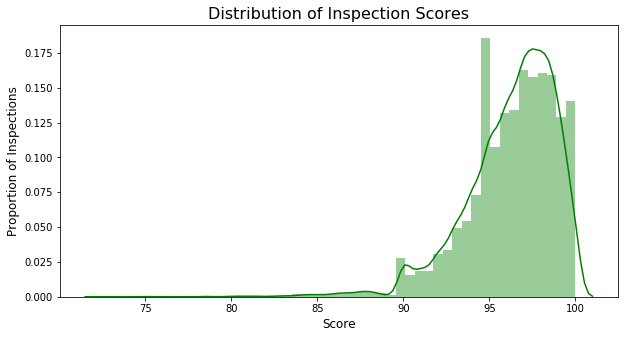

In [15]:
#adjusting figure size
plt.figure(figsize = (10,5))

#setting title
plt.title('Distribution of Inspection Scores', size = 16)

#Distribution of scores
sns.distplot(inspect['score'], color = 'g')

#setting axis labels
plt.xlabel('Score', size = 12)
plt.ylabel('Proportion of Inspections', size = 12)

This basic plot shows that generally, inspections go pretty well, given that this is a heavily left skewed distribution. If further analysis supports this, then this is great news. To get a better idea of what a typical inspection looks like, we will take a look at what sort of trends arise during the average inspection.

In [16]:
#counts the number of inspections each restaurant has received
inspection_count = (inspect['date'].groupby(inspect['hsisid'])
                       .count()
                       .to_frame()
                       .reset_index()
                       .rename(columns = {'date':'num_inspections'}))

#average score receiveed during inspections for each restaurant
inspection_score = (inspect['score'].groupby(inspect['hsisid'])
                    .mean()
                    .to_frame()
                    .reset_index()
                    .rename(columns = {'score': 'avg_score'}))

#average days passed since last inspcetion
inspection_days = (inspect['days_since_previous_inspection'].groupby(inspect['hsisid'])
                    .mean()
                    .to_frame()
                    .reset_index()
                    .rename(columns = {'days_since_previous_inspection': 'days_since_last'}))

#merging inspection_count and inspection_score dataframes
avg_inspection = inspection_count.merge(inspection_score,
                                 on = 'hsisid', how = 'outer')

#merging avg_inspection and inspection_days dataframes
avg_inspection = avg_inspection.merge(inspection_days,
                                 on = 'hsisid', how = 'outer')

In [17]:
#filling na values with 0
avg_inspection['days_since_last'] = avg_inspection['days_since_last'].fillna(0)

#rounding the average days since last inspection
avg_inspection['days_since_last'] = avg_inspection['days_since_last'].astype(int)


In [18]:
avg_inspection.corr().style.background_gradient(cmap = 'coolwarm')

,hsisid,num_inspections,avg_score,days_since_last
hsisid,1.000000,0.232012,0.189855,-0.087537
num_inspections,0.232012,1.000000,0.020184,-0.010937
avg_score,0.189855,0.020184,1.000000,0.009660
days_since_last,-0.087537,-0.010937,0.009660,1.000000


At first glance, it would seem as though these features are not all that correlated with each other. Though correlation matrices are useful, it is important to visualize data, as "U-Shaped" trends often don't show up well through this method.

Text(0, 0.5, 'Score')

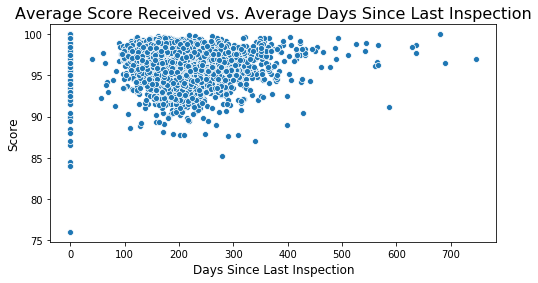

In [19]:
#adjusting figure size
plt.figure(figsize = (8,4))

#setting title
plt.title('Average Score Received vs. Average Days Since Last Inspection', size = 16)

#initializing plot
sns.scatterplot(x = 'days_since_last', y = 'avg_score', data = avg_inspection)

#setting axis labels
plt.xlabel('Days Since Last Inspection', size = 12)
plt.ylabel('Score', size = 12)

An interesting relationship. As the days since last inspection increase, scores tend to ever so slightly increase as well. This could likely be due to the fact that establishments that are particularly low risk only require a yearly inspection. Still, this fact barely accounts for outliers above 365 days. In fact, many of those low risk restaurants are likely receiving inspections sooner than the 365 day mark.

The vast majority of inspections do tend to hover around the 150-350 days mark, and most also seem to score at least a 90 (an A) on their inspections. More investigation is needed to fully understand this relationship.

Text(0, 0.5, 'Average Score')

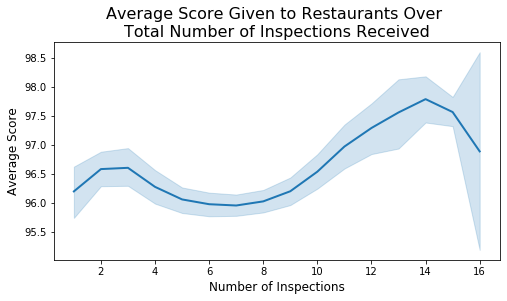

In [20]:
#adjusting figure size
plt.figure(figsize = (8,4))

#setting plot title
plt.title('Average Score Given to Restaurants Over \nTotal Number of Inspections Received', size = 16)

#initializing a line plot, adjusting linewidth for style
sns.lineplot(x = 'num_inspections', y = 'avg_score', data = avg_inspection).lines[0].set_lw(2)

#setting axis labels
plt.xlabel('Number of Inspections', size = 12)
plt.ylabel('Average Score', size = 12)

This is a light "U-shaped" relationship, as described earlier. Initial inspections perform alright, then dip. As inspections increase, scores increase as well. But most interestingly is that all of these scores are above a 95. Are restaurants really just this exceptional when it comes to health violations?

To better understand this, we must look further into the relationship between critical/non-critical violations and health scores.

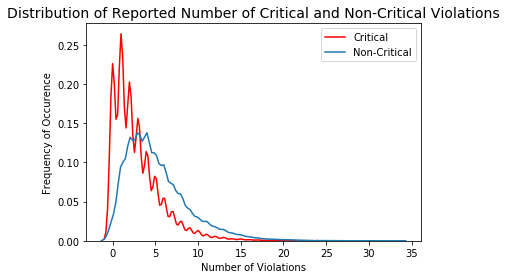

In [21]:
#plot title
plt.title('Distribution of Reported Number of Critical and Non-Critical Violations', size = 14)

#distribution of critical violations
sns.distplot(inspect['num_critical'], hist = False, color = 'r', label  = 'Critical')

#distribution of non-critical violatons
sns.distplot(inspect['num_non_critical'], hist = False, label = 'Non-Critical')

#setting x & y labels
plt.xlabel('Number of Violations')
plt.ylabel('Frequency of Occurence')

#initializing a legend
plt.legend()

This seems like a healthy distribution. Again, if these violations are being recorded properly then everythng should be in order. To confirm that higher ratings are still being graded objectively, we should expect inspections with high violation counts to perform very poorly. It is important to keep in mind that although inspections with over 10 critical or non-critical violations exist, they are not common.

(0, 100)

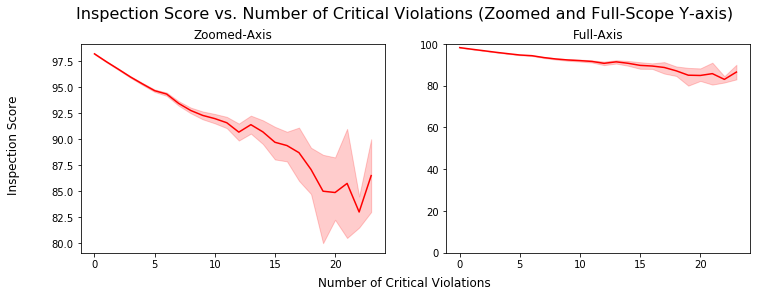

In [22]:
#initializing a subplot
f, ax = plt.subplots(1,2, figsize = (12,4))

#plot title and positioning
f.suptitle('Inspection Score vs. Number of Critical Violations (Zoomed and Full-Scope Y-axis)', size = 16)
f.subplots_adjust(top = 0.85)

#two identical lineplots
sns.lineplot(x = 'num_critical', y = 'score', data = inspect, color = 'r',  ax = ax[0])
sns.lineplot(x = 'num_critical', y = 'score', data = inspect, color = 'r', ax = ax[1])

#Setting titles for the individual subplots
ax[0].title.set_text('Zoomed-Axis')
ax[1].title.set_text('Full-Axis')

#removing seaborn x & y labels
ax[0].set(xlabel='', ylabel = '')
ax[1].set(xlabel='', ylabel = '')

#Setting  shared x & y labels
f.text(0.5, 0.01, 'Number of Critical Violations', size = 12, ha='center')
f.text(0.04, 0.5, 'Inspection Score', size = 12, va='center', rotation='vertical')

#presenting full score range for the "Full Axis" plot
ax[1].set_ylim(0,100)

There is an expected negative linear relationship between the number of critical violations a restaurant has, and the score it receives. However, the slope of this relationship is actually quite minimal, as shown by the Full-Axis plot. Additionally we see high variance in scores as violations increase. Even a small spike in ratings at the max of 23 violations! 

How do non-critical violations compare?

(0, 100)

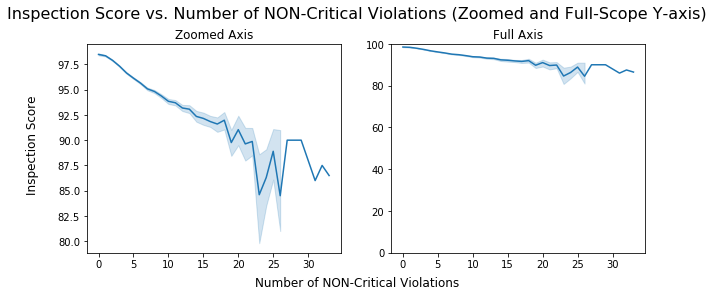

In [23]:
#initializing a subplot
f, ax = plt.subplots(1,2, figsize = (10,4))

#plot title and positioning
f.suptitle('Inspection Score vs. Number of NON-Critical Violations (Zoomed and Full-Scope Y-axis)', size = 16)
f.subplots_adjust(top = 0.85)

#two identical lineplots
sns.lineplot(x = 'num_non_critical', y = 'score', data = inspect, ax = ax[0])
sns.lineplot(x = 'num_non_critical', y = 'score', data = inspect, ax = ax[1])

#Setting titles for the individual subplots
ax[0].title.set_text('Zoomed Axis')
ax[1].title.set_text('Full Axis')

#removing seaborn x & y labels
ax[0].set(xlabel='', ylabel = '')
ax[1].set(xlabel='', ylabel = '')

#Setting  shared x & y labels
f.text(0.5, 0.01, 'Number of NON-Critical Violations', size = 12, ha='center')
f.text(0.04, 0.5, 'Inspection Score', size = 12, va='center', rotation='vertical')

#presenting full score range for the "Full Axis" plot
ax[1].set_ylim(0,100)

This plot follows the same trend as the previous, in that a light negative linear relationship is shown with increasing variance as violations increase. But most surprisingly: spike back up after the ~25 violation mark.

As these plots have shown, scoring seems to have an interesting trend of scores either spiking up, or varying wildly as the number of violations increase. On top of this, most scores never really seem to dip past the 85 score mark, despite having over 15 critical violations.

This could be for several reasons, either stemming from the violations themselves, or perhaps more seriously: the officials conducting inspections. We will investigate both.

In [24]:
#dataframe containing only inspections with a high count of critical violations
high_crit_id = inspect.loc[inspect['num_critical'] >= 12]['hsisid']

#dataframe containing only inspections with a low count of critical violations
low_crit_id = inspect.loc[inspect['num_critical'] <= 12]['hsisid']

In [25]:
#dataframe containing only violations that came from inspections with a high count critical violations
hc_viol = viol.loc[(viol['hsisid'].isin(high_crit_id)) & (viol['violationtype'] != '')]

#dataframe containing only violations that came from inspections with a low count critical violations
lc_viol = viol.loc[(viol['hsisid'].isin(low_crit_id)) & (viol['violationtype'] != '')]

In [26]:
#unique violation types
#Corrected during Inspection, Repeat, and Verification Required
hc_viol['violationtype'].unique()

array(['CDI', 'R', nan, 'VR'], dtype=object)

In [27]:
#Frequency of violation type for high violation counts
hc_viol = hc_viol['violationtype'].value_counts(normalize = True).reset_index()

#Frequency of violation type for low valuation counts
lc_viol = lc_viol['violationtype'].value_counts(normalize = True).reset_index()

In [28]:
#what the dataframes look like
hc_viol.head()

,index,violationtype
0,CDI,0.551090
1,R,0.394667
2,VR,0.054243


Text(0.04, 0.5, 'Proportion of Violations')

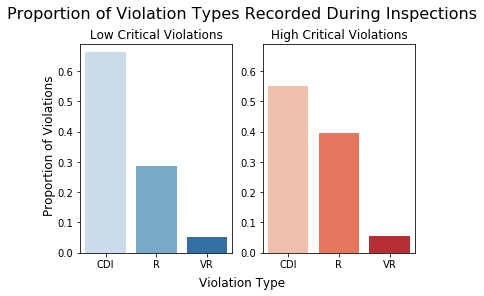

In [29]:
#initializing subplots
f, ax = plt.subplots(1, 2)

#plot title and adjusting positioning
f.suptitle('Proportion of Violation Types Recorded During Inspections', size = 16)
f.subplots_adjust(top = 0.85)

#low critical violation barplot
sns.barplot(x = 'index', y = 'violationtype', data=lc_viol,  palette = 'Blues' , ax=ax[0])

#high critical violation barplot
sns.barplot(x = 'index', y = 'violationtype', data=hc_viol,  palette =  'Reds', ax=ax[1])

#setting subplot titles
ax[0].title.set_text('Low Critical Violations')
ax[1].title.set_text('High Critical Violations')

#removing seaborn axis labels
ax[0].set(xlabel='', ylabel = '')
ax[1].set(xlabel='', ylabel = '')

#setting equal y-axis limits
ax[0].set_ylim(0,0.69)
ax[1].set_ylim(0,0.69)

#labeling figure axes
f.text(0.5, 0.01, 'Violation Type', size = 12, ha='center')
f.text(0.04, 0.5, 'Proportion of Violations', size = 12, va='center', rotation='vertical')

*CDI: Corrected During Inspection | R: Repeat | VR: Verification Required* 

This figure highlights that inspections that record a higher count of critical violations, also report more frequent repeat offenses (R). Additionally, both plots suggest that an emphasis on correcting violations during the inspection itself is common practice. 

In a well-functioning system, repeat offenders that amass a high count of critical violations should receive lower scores. But does this idea hold up in reality? In a previous plot, a light relationship was shown, but it was accompanied by increasing variance as well.

Given that critical violations are more likely to be repeated, it is good to understand exactly what offenses are most common

In [30]:
#Dataframe containing repeated critical violations
repeat = viol.loc[(viol['violationtype'] == 'R') & (viol['critical'] == 'Yes')]

#dataframe containing critical violations that were corrected during the inspections
corrected = viol.loc[(viol['violationtype'] == 'CDI') & (viol['critical'] == 'Yes')]

In [31]:
#proportion of violations by violation code for repeated violations
rep_viol = repeat['violationcode'].value_counts(normalize = True).reset_index()

#proportion of violations by violation code for violations that were corrected during the inspections
cor_viol = corrected['violationcode'].value_counts(normalize = True).reset_index()

In [32]:
#a datframe
#top 3 violations for repeated and CDI violations
top_3 = rep_viol[:3].merge(cor_viol[:3], how = 'outer', indicator = True)

#renaming columns
top_3 = top_3.rename(columns = {'index':'violation', 'violationcode':'proportion', '_merge':'Origin'})

#renaming values to indicate which dataframe the data came from
top_3['Origin'] = top_3['Origin'].replace({'left_only':'Repeat', 'right_only':'Corrected'})

Text(0, 0.5, 'Percent of Violations')

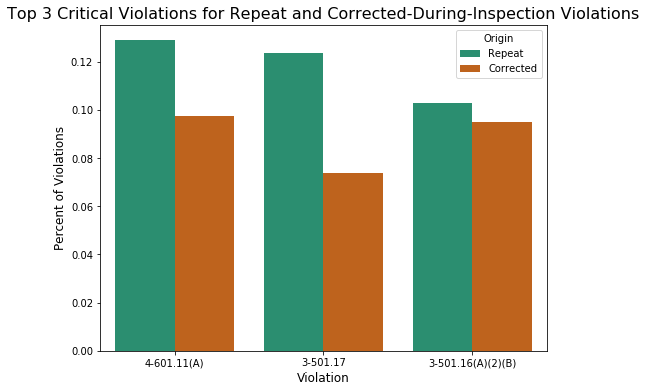

In [33]:
#figure size
plt.figure(figsize = (8,6))

#setting figure title
plt.title('Top 3 Critical Violations for Repeat and Corrected-During-Inspection Violations', size = 16)

#initializing a barplot
sns.barplot(x = 'violation', y='proportion', data = top_3, palette = 'Dark2', hue = 'Origin')

#setting x & y labels
plt.xlabel('Violation', size = 12)
plt.ylabel('Percent of Violations', size = 12)

#### Top 3 Repeat Violations are Also the Top 3 Violations Most Often Corrected During Inspections

4-601.11(A) - Food contact surfaces, non-food contact services, or utensils are dirty.

3-501.17 - Improper date markings on potentially hazardous foods.

3-501.16(A)(2)(B) - Improper hot and cold food holding due to equipment not being capable of maintaining proper food temp.

Given this trend, it is safe to identify these critical violations as very common. As shown before, there is an inconsistent approach towards scoring, where a restaurant with ~20 critical violations can expect a score anywhere from 80-90. Given the severity of of these common violations, more efforts should be taken to reduce the overlap between repeated and corrected violations through more strict scoring policies. These new policies should work to provide consistent and accurate scores that punish consistent repeated violations.

Inspectors should also be trusted to be properly enforce these rules. But given the gravity and consistency of these violations, are inspectors accurately administering scores based on objective findings? Objectivity in grading should reduce repeat violations, and ensure that the department is operating with integrity. If not, then inspections are too arbitrary.

In [34]:
#Creating a dataframe of inspectors and the percentage of inspections they have performed
exp = inspect['inspector_id'].value_counts(normalize = True).reset_index()

In [35]:
#identifying the top 10 inspectors who have conducted the most inspections
#most experienced inspectors
exp.head(10)

,index,inspector_id
0,8,0.074136
1,7,0.070508
2,15,0.068613
3,5,0.063576
4,2,0.061248
5,18,0.058053
6,16,0.057511
7,6,0.054533
8,3,0.051825
9,9,0.050200


In [36]:
#getting the inspector ids
exp = exp[:10]['index']

#dataframe that only contains inspections conducted by experienced inspectors
veterans = inspect.loc[inspect['inspector_id'].isin(exp)]

#only including relevant columns
veterans = veterans[['inspector_id', 'score', 'num_critical']]


Text(0, 0.5, 'Average Score')

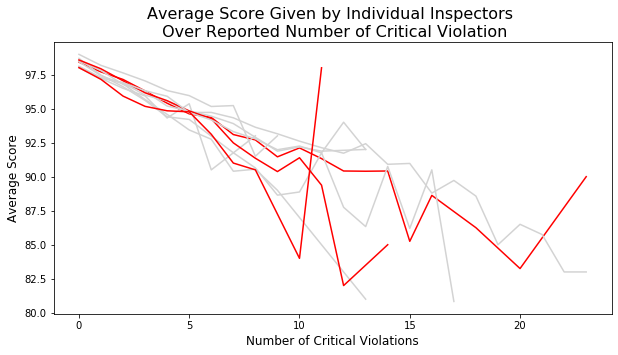

In [37]:
#adjusting figure size
plt.figure(figsize = (10,5))

#figure title and font size
plt.title('Average Score Given by Individual Inspectors \n Over Reported Number of Critical Violation', size = 16)

#noteworthy inspectors that I was able to identify
noteworthy = [exp[0], exp[6], exp[9]]

#looping through the list of experienced inspector id's
for vet in exp:
    
    #special plot for non-noteworthy inspectors
    if vet not in noteworthy:
        
        #non-notworthy inspector lineplot
        sns.lineplot('num_critical','score',
                     data = veterans.loc[veterans['inspector_id'] == vet], 
                     err_style = None, color = 'lightgray')
        
    else:
        #noteworthy inspector lineplot
        sns.lineplot('num_critical','score',
                     data = veterans.loc[veterans['inspector_id'] == vet], 
                     err_style = None, color = 'r')

#x and y labels
plt.xlabel('Number of Critical Violations', size = 12)
plt.ylabel('Average Score', size = 12)

This plot shows two key points.

1) The three inspectors in red can be expected to inflate ratings as violations begin to increase. <br>
2) Scores begin to vary greatly after five critical violations. Though not all inspectors inflate scores to the same degree as the three highlighted examples.

Keep in mind, this plot only includes the most experienced inspectors. Meaning they have each conducted at least 1000 inspections. Such trends could possibly be visible in other inspectors who have conducted less inspections, and are likely less experienced. Rather than plot every single inspector, we will statistically test to see how different these inspectors are from the group.

In [38]:
#creating a dataframe that excludes experienced inspectors
all_others = inspect.loc[~inspect['inspector_id'].isin(exp)]
all_others = all_others[['inspector_id', 'score', 'num_critical']]

In [39]:
veterans['score'].describe()

count    11268.000000
mean        96.125355
std          2.736014
min         72.500000
25%         94.500000
50%         96.500000
75%         98.000000
max        100.000000
Name: score, dtype: float64

In [40]:
all_others['score'].describe()

count    7198.000000
mean       96.407474
std         2.511344
min        75.000000
25%        95.000000
50%        97.000000
75%        98.000000
max       100.000000
Name: score, dtype: float64

In [41]:
stat, pval = stats.ttest_ind(all_others['score'], veterans['score'])

In [42]:
print('T-test Results')
if pval < 0.01:
    print('Probably Different From the Group. \nP-value:', pval)
else:
    print('Probably the Same as the Group \nP-value:', pval)

T-test Results
Probably Different From the Group. 
P-value: 1.804499157670652e-12


Here we got a p-value that is basically 0, meaning that the two groups are likely rating differently. This can potentially be good or bad news. Different in a good way would mean other inspectors are being more objective and scoring establishments with integrity. Different in a bad way would mean the rest of the group is potentially even *more* volatile in their ratings. To examine this, I will look at trends within less experienced inspectors. To improve the robustness of my findings, these inspectors will have had to complete at least 100 inspections each.

In [43]:
#Creating a dataframe of inspectors and the percentage of inspections they have performed
low_exp = inspect['inspector_id'].value_counts().reset_index()

In [44]:
#identifying less experienced inspectors who have conducted at least 100 inspections
#bottom 10 with at least 100 inspections
#only selecting inspector id's
low_exp = low_exp[16:26]['index']

In [45]:
#dataframe that only contains inspections conducted by experienced inspectors
newbies = inspect.loc[inspect['inspector_id'].isin(low_exp)]

#only including relevant columns
newbies = newbies[['inspector_id', 'score', 'num_critical']]

(0, 18)

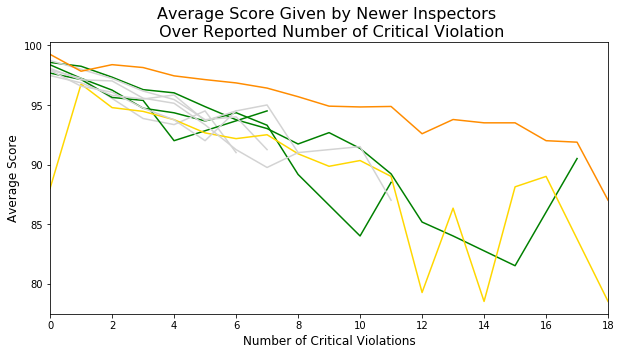

In [46]:
#adjusting figure size
plt.figure(figsize = (10,5))

#figure title and font size
plt.title('Average Score Given by Newer Inspectors \n Over Reported Number of Critical Violation', size = 16)

#noteworthy inspectors that I was able to identify
noteworthy_low_exp = [low_exp[16], low_exp[18], low_exp[19], low_exp[21], low_exp[22]]

#looping through the list of experienced inspector id's
for insp in low_exp:
    
    #special plot for non-noteworthy inspectors
    if insp not in noteworthy_low_exp:
        
        #non-notworthy inspector lineplot
        sns.lineplot('num_critical','score',
                     data = newbies.loc[newbies['inspector_id'] == insp], 
                     err_style = None, color = 'lightgray')
    
    elif insp == low_exp[21]:
        #a special inspector
        sns.lineplot('num_critical','score',
                     data = newbies.loc[newbies['inspector_id'] == insp], 
                     err_style = None, color = 'gold')
        
    elif insp == low_exp[22]:
        #another special inspector
        sns.lineplot('num_critical','score',
                     data = newbies.loc[newbies['inspector_id'] == insp], 
                     err_style = None, color = 'darkorange')
        
    else:
        #noteworthy inspector lineplot
        sns.lineplot('num_critical','score',
                     data = newbies.loc[newbies['inspector_id'] == insp], 
                     err_style = None, color = 'green')

#x and y labels
plt.xlabel('Number of Critical Violations', size = 12)
plt.ylabel('Average Score', size = 12)

#x axis limits
plt.xlim(0,18)

Here we see the trademark "V" shape trend that is characteristic of score inflation. Although these inspectors have not encountered cases where the number critical violations has exceed 18, they still show high volatility in their scoring. The inspector in yellow is a particularly interesting case, as their scoring methods show a highly zig-zagged trend. The inspector in orange that hovers above all the rest could be another sign of score inflation. While they do follow a negative linear trend, the average score they give out doesn't shoot below a 90 until 18 critical violations are recorded.

This sort of inconsistent scoring pattern could be problematic. Both the inexperienced and experienced groups showed high volatility in ratings, as well as tendency to inflate scores.

These varying ratings can have many different explanations, but it is easy to see why our t-test determined that the two groups are different. To further measure differences, I will create an Ordinary Least Squares model with the inexperienced and experienced inspectors, compared to the inbetweens. Additionally I will compare homogenity of scoring variance using a Levene test. I chose the Levene test over a Bartlett test because as we saw in an early visualization, scores are heavily skewed left and not normally distributed

In [47]:
#excluding inexperienced insepctors from the all_others dataframe
all_others = all_others.loc[~all_others['inspector_id'].isin(low_exp)]

In [48]:
#levene test for variance homogenity
stat2, pval2 = stats.levene(newbies['score'], veterans['score'], all_others['score']) 

In [49]:
#printing results
print('Levene Test Results')
if pval2 < 0.01:
    print('Probably Different Variances. \nP-value:', pval2)
else:
    print('Probably Similar Variances \nP-value:', pval2)

Levene Test Results
Probably Different Variances. 
P-value: 1.7942854731212557e-39


Results indicate that each group has different variance in scores. The trend of score inconsistency could likely be present in the entire agency.

In [50]:
#preparing a dataframe for OLS model
#merging newbies and veterans data frame
test = newbies.merge(veterans, how = 'outer', indicator = True)

#renaming column
test = test.rename(columns = {'_merge':'Origin'})

#renaming values to indicate which dataframe the data came from
test['Origin'] = test['Origin'].replace({'left_only':'newbies', 'right_only':'veterans'})

#repeating process to add in all_others dataframe
test = test.merge(all_others, how = 'outer', indicator = True)

test['Origin'] = test['Origin'].replace(np.nan, 'all_others')

#dropping column
test = test.drop(columns = '_merge')

In [51]:
#Ordinary Least Squares model for scores
score_mod = ols('score ~ C(Origin)', data=test).fit()

#presenting results as a table
anova_table_score = sm.stats.anova_lm(score_mod, typ=2)
anova_table_score

,sum_sq,df,F,PR(>F)
C(Origin),1144.214041,2.0,81.921678,3.791423e-36
Residual,128937.933866,18463.0,NaN,NaN


With a p-value of 0, we can conclude that the groups differ in score.

In [52]:
#Ordinary Least Squares model for number of critical violations
viol_mod = ols('num_critical ~ C(Origin)', data=test).fit()

#presenting results as a table
anova_table_viol = sm.stats.anova_lm(viol_mod, typ=2)
anova_table_viol

,sum_sq,df,F,PR(>F)
C(Origin),1482.137506,2.0,94.829805,1.061772e-41
Residual,144283.249313,18463.0,NaN,NaN


The groups also differ significantly in the number of critical violations they experience.

These results lead me to reject the null hypothesis and affirm that some inspections may be experiencing inflated scores. The agency as a whole is lacking a standardized practice that ensures objectivity and integrity in scoring.

# Ethics & Privacy

All restaurant names and specific addresses have been kept private. To ensure inspectors remained anonymous, names were removed and ID's were given arbitrary tags. The biggest ethical complaint is that I'm sure many of the livelihoods of restaurant owners and employees depend on the restaurant remaining open. However, these restaurants have a duty to provide clean food for guests and safe working conditions for their employees. There should be no compromise. Likewise with inspectors, it is their responsibility to provide accurate scoring. Specific employee identities will be kept private, as no plot gives specific information on who exactly is responsible for rating inflations.

# Conclusion & Discussion

Critical violations are more likely than non-critical violations to be repeated. Additionally, the top 3 most common most critical violations that are correctd during inspections, are also the top 3 most common repeat violations. Lastly, inspection scoring variance tends to increase as violations (both critical and non-critical) increase. These findings suggest that the health inspection criteria are approaching arbitrariness and should be reformed to further discourage repeat offenses. A more consistent grading system would give restaurants the score they have earned and provide the most accurate results.

It also seems as though some inspectors are inflating inspection scores, further fanning the flames of this arbitrary grading. The exact motives for this cannot be confirmed here, but it should be noted that both parties (the restaurant and the inspecting agency) have something to gain from this. As violations pile up, a restaurants score is likely to decrease. Once a certain threshold is reached, the restaurant must close down, fix its violations, and be inspected once more. This process is both costly and time-consuming for an agency that is underfunded, and a restaurant that needs to stay in business.

Though score inflation could also be explained by other activities such as the nature of the violations. Our visualizations showed that it is rare for inspections to report over 10 critical violations. Perhaps the answer to this problem could be to further narrow down which violations count the most, and which are unneccesary. This fact should be kept in mind when extrapolating these findings to the greater population. 

The Top 3 violations that were identified should likely have their weights increased to discourage future infractions. Along with this, further narrowing down violations could improve scoring accuracy and consistency. Nonetheless, Wake county should ensure that its inspecting force is performing with integrity, and that they are being equipped with the right criteria that will give restaurants the scores they have earned.